<a href="https://colab.research.google.com/github/akanksha-th/brain_tumor_mri_classification/blob/master/replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, math, numpy as np, random, time
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
print(f'Torch version: {torch.__version__}')

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Torch version: 2.8.0+cu126
Using device: cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(150),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize
    ]),

    # Just normalization for validation
    'valid': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),

    ]),
}

In [5]:
data_dir = '/content/drive/MyDrive/Tumour'

image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
               for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_dataset[x], batch_size=8, shuffle=True, num_workers=2, persistent_workers=True)
               for x in ['train', 'valid']}

dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'valid']}
class_names = image_dataset['train'].classes

print(f'Classes: {class_names}')
print(f'Dataset sizes: {dataset_sizes}')
print(f'Number of training batches: {dataloaders["train"].__len__()}')
print(f'Number of validation batches: {dataloaders["valid"].__len__()}')

Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Dataset sizes: {'train': 1695, 'valid': 502}
Number of training batches: 212
Number of validation batches: 63


In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

print(f'Input batch shape: {inputs.size()}')

Input batch shape: torch.Size([8, 3, 150, 150])


In [7]:
class SepConv2d(nn.Module):
    """Separable Convolution = Depthwise Convolution + Pointwise Convolution"""
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False):
        super().__init__()
        self.depth = nn.Conv2d(in_ch, in_ch, kernel_size=kernel_size, stride=stride,
                               padding=padding, groups=in_ch, bias=bias)
        self.point = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, bias=bias)

    def forward(self, x):
        x = self.depth(x)
        x = self.point(x)
        return x


class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        reduced = max(1, channels // reduction)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, reduced)
        self.fc2 = nn.Linear(reduced, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = torch.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y


class ConvBlock(nn.Module):
    """ConvBlock: SepConv -> BN -> MaxPool -> SEBlock"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.seq = nn.Sequential(
            SepConv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            SEBlock(out_ch)
        )

    def forward(self, x):
        x = self.seq(x)
        return x

In [8]:
class LightCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):
        super().__init__()
        self.block1 = ConvBlock(in_channels, 32)
        self.block2 = ConvBlock(32, 64)
        self.block3 = ConvBlock(64, 128)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, 128)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        logits = self.fc3(x)
        return logits


model = LightCNN(in_channels=3, num_classes=len(class_names)).to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params}\nTotal Trainable Parameters: {trainable_params}")

Total params: 39629
Total Trainable Parameters: 39629


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [10]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    pbar = tqdm(dataloader, desc='train', leave=False)
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        preds = torch.argmax(outputs, dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='valid', leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc, all_preds, all_labels

In [11]:
NUM_EPOCHS = 50
best_val_acc = 0.0
best_model_path = 'best_custom_model.pth'
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)

    scheduler.step(val_loss)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"    train_loss: {train_loss:.4f}    train_acc: {train_acc:.4f}")
    print(f"    val_loss: {val_loss:.4f}    val_acc: {val_acc:.4f}")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'class_names': class_names
        }, best_model_path)
        print(f"Saved new best model")

total_time = time.time() - start_time
print(f"Training Complete in {total_time/60:.2f} minutes. Best val acc: {best_val_acc:.4f}'")

Epoch 1/50


    train_loss: 1.1894    train_acc: 0.4708
    val_loss: 1.0750    val_acc: 0.5438
Saved new best model
Epoch 2/50


    train_loss: 1.0384    train_acc: 0.5776
    val_loss: 0.8643    val_acc: 0.6614
Saved new best model
Epoch 3/50


    train_loss: 1.0037    train_acc: 0.6047
    val_loss: 1.0689    val_acc: 0.5000
Epoch 4/50


    train_loss: 0.9477    train_acc: 0.6277
    val_loss: 0.7534    val_acc: 0.7052
Saved new best model
Epoch 5/50


    train_loss: 0.9589    train_acc: 0.6171
    val_loss: 1.1926    val_acc: 0.5259
Epoch 6/50


    train_loss: 0.9509    train_acc: 0.6242
    val_loss: 0.8079    val_acc: 0.6793
Epoch 7/50


    train_loss: 0.9381    train_acc: 0.6283
    val_loss: 0.8332    val_acc: 0.6454
Epoch 8/50


    train_loss: 0.8792    train_acc: 0.6472
    val_loss: 0.7631    val_acc: 0.7092
Saved new best model
Epoch 9/50


    train_loss: 0.8802    train_acc: 0.6667
    val_loss: 0.7555    val_acc: 0.6972
Epoch 10/50


    train_loss: 0.8354    train_acc: 0.6708
    val_loss: 0.8865    val_acc: 0.6673
Epoch 11/50


    train_loss: 0.8155    train_acc: 0.6938
    val_loss: 0.9290    val_acc: 0.6394
Epoch 12/50


    train_loss: 0.8104    train_acc: 0.6832
    val_loss: 0.6982    val_acc: 0.7112
Saved new best model
Epoch 13/50


    train_loss: 0.8020    train_acc: 0.6796
    val_loss: 0.6099    val_acc: 0.7988
Saved new best model
Epoch 14/50


    train_loss: 0.7659    train_acc: 0.6956
    val_loss: 0.5460    val_acc: 0.8247
Saved new best model
Epoch 15/50


    train_loss: 0.7664    train_acc: 0.7086
    val_loss: 1.4662    val_acc: 0.5100
Epoch 16/50


    train_loss: 0.7330    train_acc: 0.7263
    val_loss: 0.6584    val_acc: 0.7311
Epoch 17/50


    train_loss: 0.7671    train_acc: 0.7021
    val_loss: 0.7272    val_acc: 0.7191
Epoch 18/50


    train_loss: 0.7636    train_acc: 0.7009
    val_loss: 0.9352    val_acc: 0.6255
Epoch 19/50


    train_loss: 0.7150    train_acc: 0.7209
    val_loss: 0.5799    val_acc: 0.7729
Epoch 20/50


    train_loss: 0.7171    train_acc: 0.7209
    val_loss: 0.7198    val_acc: 0.6892
Epoch 21/50


    train_loss: 0.6963    train_acc: 0.7292
    val_loss: 0.9185    val_acc: 0.6135
Epoch 22/50


    train_loss: 0.7057    train_acc: 0.7434
    val_loss: 0.5669    val_acc: 0.7928
Epoch 23/50


    train_loss: 0.6658    train_acc: 0.7316
    val_loss: 0.5168    val_acc: 0.8207
Epoch 24/50


    train_loss: 0.6818    train_acc: 0.7381
    val_loss: 0.9086    val_acc: 0.6315
Epoch 25/50


    train_loss: 0.6726    train_acc: 0.7510
    val_loss: 0.6781    val_acc: 0.7052
Epoch 26/50


    train_loss: 0.6550    train_acc: 0.7422
    val_loss: 0.6470    val_acc: 0.7430
Epoch 27/50


    train_loss: 0.6634    train_acc: 0.7440
    val_loss: 0.6008    val_acc: 0.7590
Epoch 28/50


    train_loss: 0.6466    train_acc: 0.7528
    val_loss: 0.6740    val_acc: 0.7211
Epoch 29/50


    train_loss: 0.6360    train_acc: 0.7552
    val_loss: 0.5534    val_acc: 0.7888
Epoch 30/50


    train_loss: 0.6683    train_acc: 0.7463
    val_loss: 0.6344    val_acc: 0.7450
Epoch 31/50


    train_loss: 0.6765    train_acc: 0.7434
    val_loss: 0.5190    val_acc: 0.8327
Saved new best model
Epoch 32/50


    train_loss: 0.6575    train_acc: 0.7528
    val_loss: 0.5043    val_acc: 0.8327
Epoch 33/50


    train_loss: 0.6419    train_acc: 0.7493
    val_loss: 0.6033    val_acc: 0.7530
Epoch 34/50


    train_loss: 0.6581    train_acc: 0.7404
    val_loss: 0.6016    val_acc: 0.7729
Epoch 35/50


    train_loss: 0.6623    train_acc: 0.7487
    val_loss: 0.4983    val_acc: 0.8406
Saved new best model
Epoch 36/50


    train_loss: 0.6447    train_acc: 0.7504
    val_loss: 0.5550    val_acc: 0.7928
Epoch 37/50


    train_loss: 0.6223    train_acc: 0.7593
    val_loss: 0.6140    val_acc: 0.7590
Epoch 38/50


    train_loss: 0.6432    train_acc: 0.7569
    val_loss: 0.5561    val_acc: 0.7948
Epoch 39/50


    train_loss: 0.6175    train_acc: 0.7622
    val_loss: 0.6930    val_acc: 0.7032
Epoch 40/50


    train_loss: 0.6219    train_acc: 0.7658
    val_loss: 0.5839    val_acc: 0.7948
Epoch 41/50


    train_loss: 0.6677    train_acc: 0.7422
    val_loss: 0.5874    val_acc: 0.7789
Epoch 42/50


    train_loss: 0.6525    train_acc: 0.7546
    val_loss: 0.6567    val_acc: 0.7231
Epoch 43/50


    train_loss: 0.6440    train_acc: 0.7546
    val_loss: 0.6592    val_acc: 0.7251
Epoch 44/50


    train_loss: 0.6586    train_acc: 0.7493
    val_loss: 0.5896    val_acc: 0.7769
Epoch 45/50


    train_loss: 0.6368    train_acc: 0.7569
    val_loss: 0.6291    val_acc: 0.7510
Epoch 46/50


    train_loss: 0.6214    train_acc: 0.7617
    val_loss: 0.5628    val_acc: 0.7908
Epoch 47/50


    train_loss: 0.6382    train_acc: 0.7499
    val_loss: 0.5695    val_acc: 0.7928
Epoch 48/50


    train_loss: 0.6571    train_acc: 0.7440
    val_loss: 0.6141    val_acc: 0.7610
Epoch 49/50


    train_loss: 0.6713    train_acc: 0.7457
    val_loss: 0.6060    val_acc: 0.7570
Epoch 50/50


    train_loss: 0.6294    train_acc: 0.7622
    val_loss: 0.7042    val_acc: 0.7112
Training Complete in 13.58 minutes. Best val acc: 0.8406'


In [12]:
ckpt = torch.load(best_model_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.to(device)

val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)
print('Final validation loss: {:.4f}, acc: {:.4f}'.format(val_loss, val_acc))

Final validation loss: 0.4983, acc: 0.8406


Confusion Matrix:
 [[156   5   0   0]
 [ 18  86  14   6]
 [  7   7  85   0]
 [  5  18   0  95]]
Classification Report:
               precision    recall  f1-score   support

      glioma     0.8387    0.9689    0.8991       161
  meningioma     0.7414    0.6935    0.7167       124
    no_tumor     0.8586    0.8586    0.8586        99
   pituitary     0.9406    0.8051    0.8676       118

    accuracy                         0.8406       502
   macro avg     0.8448    0.8315    0.8355       502
weighted avg     0.8425    0.8406    0.8386       502



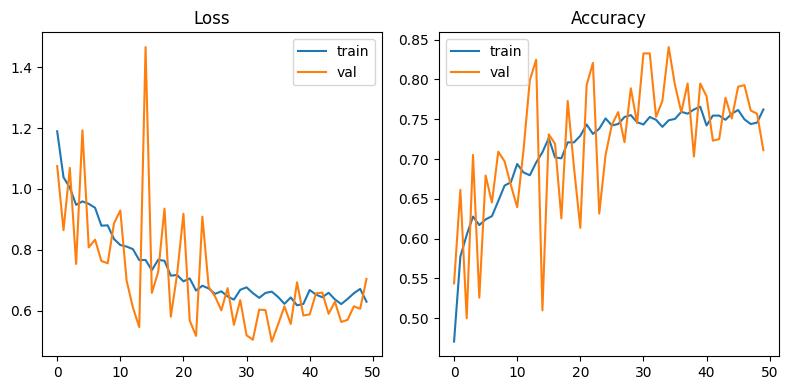

In [13]:
val_preds = np.concatenate(val_preds)
val_labels = np.concatenate(val_labels)

cm = confusion_matrix(val_labels, val_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(val_labels, val_preds, target_names=class_names, digits=4))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.plot(history['train_loss'], label='train'); plt.plot(history['val_loss'], label='val'); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history['train_acc'], label='train'); plt.plot(history['val_acc'], label='val'); plt.title("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()